# Results of SR-lite assessment with Alaska VHR
Paul Montesano Jan 2023  
__Manuscript:__ IGARSS submisttion on SR-lite workflow  

In [1]:
source('/home/pmontesa/code/3dsi/plot_functions.R')

In [11]:
library(tidyverse)
library(stringr)
library(fs)
library(glue)
library(viridis)
library(patchwork)

library(sf)

install.packages("remotes")
library(remotes)
remotes::install_github('https://github.com/ropensci/rnaturalearthhires')
library(rnaturalearthhires)
library(rnaturalearth)

Skipping install of 'rnaturalearthhires' from a github remote, the SHA1 (c3785a8c) has not changed since last install.
  Use `force = TRUE` to force installation



# Read global metrics (by image, band)

In [3]:
srlite_metrics_df = read.csv('/explore/nobackup/people/pmontesa/srlite/srlite_diagnostics_20221028/global/metrics_by_scene_method_band.csv')
# remove chars in slope col
srlite_metrics_df$slope = as.numeric(gsub("\\[|\\]","", srlite_metrics_df$slope))
# Get catid field
srlite_metrics_df = srlite_metrics_df %>% tidyr::separate(scene,  into = c('sensor', NA, NA, "catid"))

In [4]:
smry = srlite_metrics_df %>% dplyr::filter(region == 'Alaska') %>%
    group_by(catid, region, sensor) %>%
    dplyr::summarize(n=n()) %>%
    group_by(region, sensor) %>%
    dplyr::summarize(n_catid=n())
smry
sum(smry$n_catid)

`summarise()` has grouped output by 'catid', 'region'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.


region,sensor,n_catid
<chr>,<chr>,<int>
Alaska,GE01,24
Alaska,QB02,4
Alaska,WV02,122
Alaska,WV03,21


[1] 171

## Comparisons of linear models on-the-fly (OTF): EVHR TOA vs CCDC_SR
#### Global metrics for a batch (Alaska)

Longer wavelengths show higher TOA 30m vs reference SR (CCDC) r2 values

In [5]:
# Reorder comparisons
srlite_metrics_df$comparison = factor(srlite_metrics_df$comparison, levels = c(
                                         'EVHR OTF OLS vs. CCDC SR',
                                         'EVHR OTF Huber vs. CCDC SR',
                                         'EVHR OTF RMA vs. CCDC SR', 
                                         'EVHR SRLite vs. CCDC SR',
                                         'EVHR SRLite vs. EVHR TOA', 
                                         'EVHR TOA vs. CCDC SR'
                                        )
                )

# Re-label facets
model_type_labels = c('OLS','Huber','RMA')
band_name_labels  = c('Blue','Green','Red', 'NIR')

names(model_type_labels) = levels(factor(srlite_metrics_df$comparison))[1:3]
names(band_name_labels) = levels(factor(srlite_metrics_df$band))

model_type_labels
band_name_labels
# model_type_labeller <- function(variable,value){
#   return(model_type_labels[value])
# }

EVHR OTF OLS vs. CCDC SR EVHR OTF Huber vs. CCDC SR 
                     "OLS"                    "Huber" 
  EVHR OTF RMA vs. CCDC SR 
                     "RMA"

Blue   Green     NIR     Red 
 "Blue" "Green"   "Red"   "NIR"

### Why are the *comparison* groups all the same?


In [33]:
names(df_tmp)

[1] "X"                   "Unnamed..0"          "index"              
 [4] "region"              "sensor"              "catid"              
 [7] "band"                "version"             "intercept"          
[10] "slope"               "score"               "r2_score"           
[13] "explained_variance"  "mbe"                 "mae"                
[16] "mape"                "medae"               "rmse"               
[19] "mean_ccdc_sr"        "mean_evhr_srlite"    "mae_norm"           
[22] "rmse_norm"           "comparison"          "mean_evhr_toa"      
[25] "model"               "mean_evhr_otf_rma"   "mean_evhr_otf_ols"  
[28] "mean_evhr_otf_huber"

In [30]:
options(repr.plot.width = 10, repr.plot.height = 5)

srlite_metrics_df$band = factor(srlite_metrics_df$band, levels=c('Blue', 'Green', 'Red', 'NIR'))

REGION = 'Alaska'

df_tmp = srlite_metrics_df %>% 
    dplyr::filter((region == REGION) & 
                  #(explained_variance >=-999) & # why was this here?
                  str_detect(comparison, 'OTF'))  %>% 
    droplevels()

levels(df_tmp$comparison) = model_type_labels
df_tmp$band = factor(df_tmp$band, levels=c('Blue', 'Green', 'Red', 'NIR'))

smry = df_tmp %>% 
    #dplyr::filter(str_detect(comparison, 'OTF')) %>%
    #dplyr::filter(explained_variance >=-999) %>%
    dplyr::group_by(band, region, comparison) %>%
    dplyr::summarize(
        r2_score_median = median(r2_score),
        slope_median = median(slope),
        int_median = median(intercept)
        ) %>%
    dplyr::mutate(comparison = factor(comparison))

smry$band = factor(smry$band, levels=c('Blue', 'Green', 'Red', 'NIR'))
levels(smry$comparison) = model_type_labels

geom_list = list( 
        scale_fill_viridis_d(option='viridis'),
        scale_color_viridis_d(option='viridis') ,
        # facet_grid(comparison ~ band ,
        #            labeller = labeller(comparison = as_labeller(model_type_labels),
        #                                          band = as_labeller(band_name_labels))
        #           ) ,
        theme_bw(),
        theme(text=element_text(size=16)),
        labs(caption=paste0('Batch: ',REGION))
    )

hist_r2_score = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=r2_score, fill=comparison), binwidth=0.1, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=r2_score_median), color='black', linetype = 'dashed', size=1) +
        geom_list

hist_slope = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=slope, fill=comparison), binwidth=0.1, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=slope_median), color='black', linetype = 'dashed', size=1)+
        geom_list

hist_int = df_tmp %>%
    ggplot() +
        geom_histogram(aes(x=intercept, fill=comparison), binwidth=0.01, show.legend=FALSE) + 
        geom_vline(data=smry %>% 
                   dplyr::filter(region == REGION) %>% 
                   droplevels(), 
                   aes(xintercept=int_median), color='black', linetype = 'dashed', size=1)+
        geom_list

`summarise()` has grouped output by 'band', 'region'. You can override using the `.groups` argument.



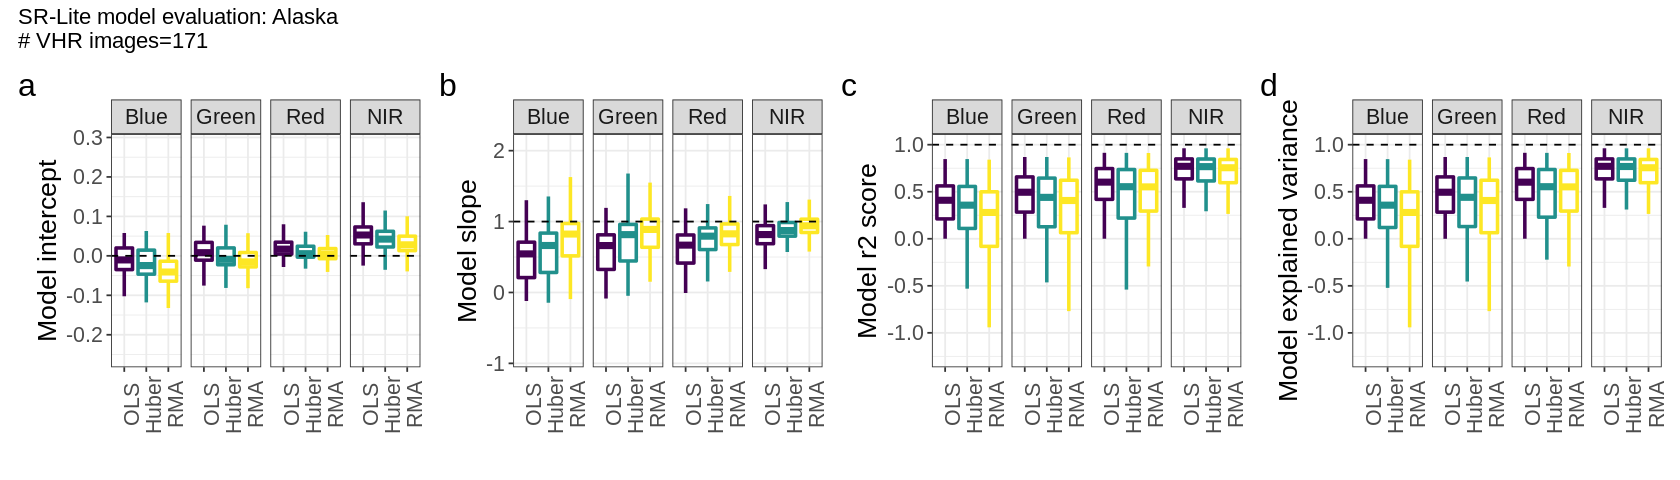

In [36]:
options(repr.plot.width = 14, repr.plot.height = 4)

make_model_stats_boxplots <- function(df_tmp, y, y_name, y_intercept){
    box_p = df_tmp %>%
        ggplot() +
        geom_boxplot(aes(y= {{ y }} , x=comparison, color=comparison), size=1, show.legend=FALSE, outlier.shape = NA) +
        geom_hline(aes(yintercept=y_intercept), linetype='dashed')+
        geom_list +
        facet_grid(. ~ band ,
                           # labeller = labeller(comparison = as_labeller(model_type_labels),
                           #                               band = as_labeller(band_name_labels))
                          ) +
        theme(axis.text.x = element_text(angle=90)) +
        labs(y=y_name, x='', caption=NULL)
    }

layout = "
ABCD
"
NUM_VHR = length(levels(factor(df_tmp$catid)))

make_model_stats_boxplots(df_tmp, intercept, 'Model intercept', y_intercept=0) + #box_slope + box_r2 +
make_model_stats_boxplots(df_tmp, slope, 'Model slope', y_intercept=1) +
make_model_stats_boxplots(df_tmp, r2_score, 'Model r2 score', y_intercept=1) +
make_model_stats_boxplots(df_tmp, explained_variance, 'Model explained variance', y_intercept=1) +
    plot_layout(design = layout, guides = "collect") +
    plot_annotation(tag_levels = 'a', title=paste0('SR-Lite model evaluation: ', REGION, '\n# VHR images=', NUM_VHR ) ) 

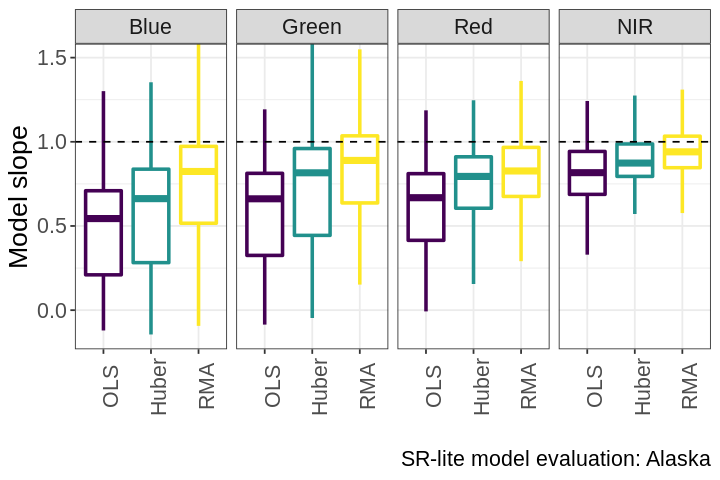

In [37]:
options(repr.plot.width = 6, repr.plot.height = 4)
p = make_model_stats_boxplots(df_tmp, slope, 'Model slope', y_intercept=1)
p + labs(caption = paste0('SR-lite model evaluation: ', REGION )) + coord_cartesian(ylim = c(-0.15,1.5))

In [9]:
quantile(df_tmp.m$value, na.rm=TRUE)[2]

ERROR: Error in quantile(df_tmp.m$value, na.rm = TRUE): object 'df_tmp.m' not found


In [ ]:
options(repr.plot.width = 20, repr.plot.height = 10)

library(reshape2)

stats_cols_list = c('intercept','slope','score','r2_score','explained_variance','mbe','mae','mape','medae','rmse','mean_ccdc_sr','mean_evhr_srlite','mae_norm','rmse_norm','comparison')
df_tmp.m = melt(df_tmp %>% dplyr::select(region, scene, band, all_of(stats_cols_list)), id_vars = c('region', 'scene', 'band'))

df_tmp.m %>% 
        ggplot() +
        geom_boxplot(aes(y= value , x=comparison, color=comparison), size=1, show.legend=FALSE, outlier.shape = NA) +
        #geom_hline(aes(yintercept=y_intercept), linetype='dashed')+
        geom_list +
        facet_wrap(band~variable , scales="free_y", ncol=length(stats_cols_list)-1
                           # labeller = labeller(comparison = as_labeller(model_type_labels),
                           #                               band = as_labeller(band_name_labels))
                          ) +
        #scale_y_continuous(limits=c(quantile(df_tmp.m$value, na.rm=TRUE)[2] - 1.5*IQR(df_tmp.m$value, na.rm=TRUE), quantile(df_tmp.m$value, na.rm=TRUE)[4] + 1.5*IQR(df_tmp.m$value, na.rm=TRUE) )) +
        theme(axis.text.x = element_text(angle=90)) +
        labs(x='', caption=NULL)

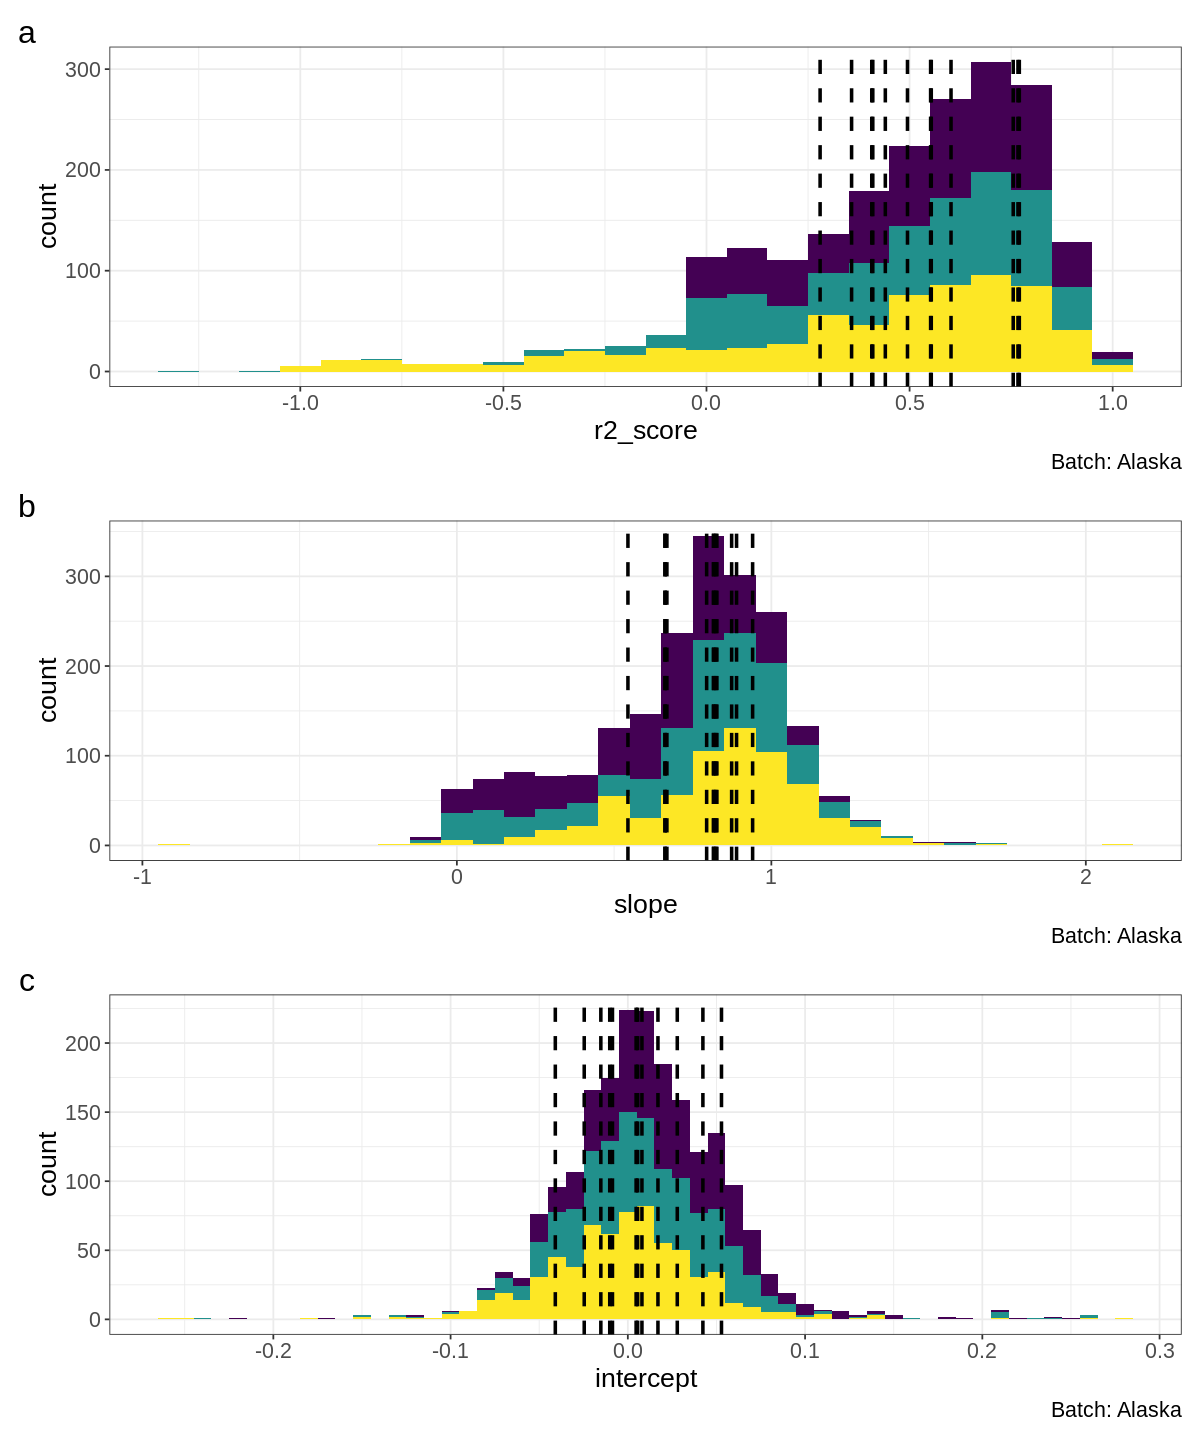

In [10]:
options(repr.plot.width = 10, repr.plot.height = 12)

layout = "
A
B
C
"

hist_r2_score + hist_slope + hist_int +
    plot_layout(design = layout, guides = "collect") +
    plot_annotation(tag_levels = 'a') #+ theme(plot.tag = element_text(size = 26))

# Read in global SAMPLE of pixels (0.1%) of each image

### Sample of reflectance from 30m pixels from the stack of SRLite output, TOA input, and CCDC input (with common mask applied)
From all batches, a sample of 0.001 of the pixels is used to compare results across all images, bands, and linear models

In [11]:
sample_reflectance_table_fn = '/explore/nobackup/people/pmontesa/srlite/srlite_diagnostics_20221028/global/global_from_sample_p001.csv'

In [12]:
reflect_df <- read_csv(sample_reflectance_table_fn) %>%
  select(file_name, everything(), -`...1`) %>%
  rename(path = file_name) %>%
  mutate(file = path_file(path),
         region = str_split_fixed(file, '_', 6)[,1],
         satellite = str_split_fixed(file, '_', 6)[,2],
         yyyymmdd = str_split_fixed(file, '_', 6)[,3],
         prod_code = str_split_fixed(file, '_', 6)[,4],
         catid = str_split_fixed(file, '_', 6)[,5])

reflectances <- tibble(ReflectanceType = c('CCDC_SR','EVHR_TOA','EVHR_SRLite','EVHR_OTF_RMA','EVHR_OTF_OLS','EVHR_OTF_Huber'))
                       # ReflectanceTypePretty = c('CCDC SR', 'EVHR TOAR', 'EVHR SRLite', 'EVHR OTF RMA SR', 'EVHR OTF OLS SR', 'EVHR OTF Huber'))
bands <- tibble(Band = c('Blue','Green','Red','NIR'),
                Band_so = c(1,2,3,4)) %>%
  mutate(Band = fct_reorder(Band, Band_so)) %>%
  select(-Band_so)

reflectances_bands <- crossing(reflectances, bands) %>%
  mutate(name = glue('{ReflectanceType}{Band}'))

reflect_df_longer <- reflect_df %>%
  pivot_longer(cols=where(is.numeric), values_to='Reflectance') %>%
  left_join(reflectances_bands) %>%
  select(-name)

reflect_df_long <- reflect_df_longer %>%
  group_by(path, ReflectanceType) %>%
  mutate(row = row_number()) %>%
  pivot_wider(names_from=ReflectanceType, values_from=Reflectance) %>%
  select(-row) %>%
  ungroup()

New names:
* `` -> ...1

Rows: 414163 Columns: 26

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): file_name
dbl (25): ...1, CCDC_SRBlue, CCDC_SRGreen, CCDC_SRRed, CCDC_SRNIR, EVHR_TOAB...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Joining, by = "name"



In [13]:
smry_num_images = reflect_df %>%
    dplyr::filter(region == 'Alaska') %>% 
    dplyr::group_by(catid, satellite) %>% 
    dplyr::summarize(n_bands = n()) %>% 
    dplyr::group_by(satellite) %>% 
    dplyr::summarize(n_catid = n())
smry_num_images
sum(smry_num_images$n_catid)

`summarise()` has grouped output by 'catid'. You can override using the `.groups` argument.



satellite,n_catid
<chr>,<int>
GE01,24
QB02,4
WV02,121
WV03,21


[1] 170

In [14]:
# Get unique list of final catids for analysis
catid_list = levels( factor(reflect_df$catid ))

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



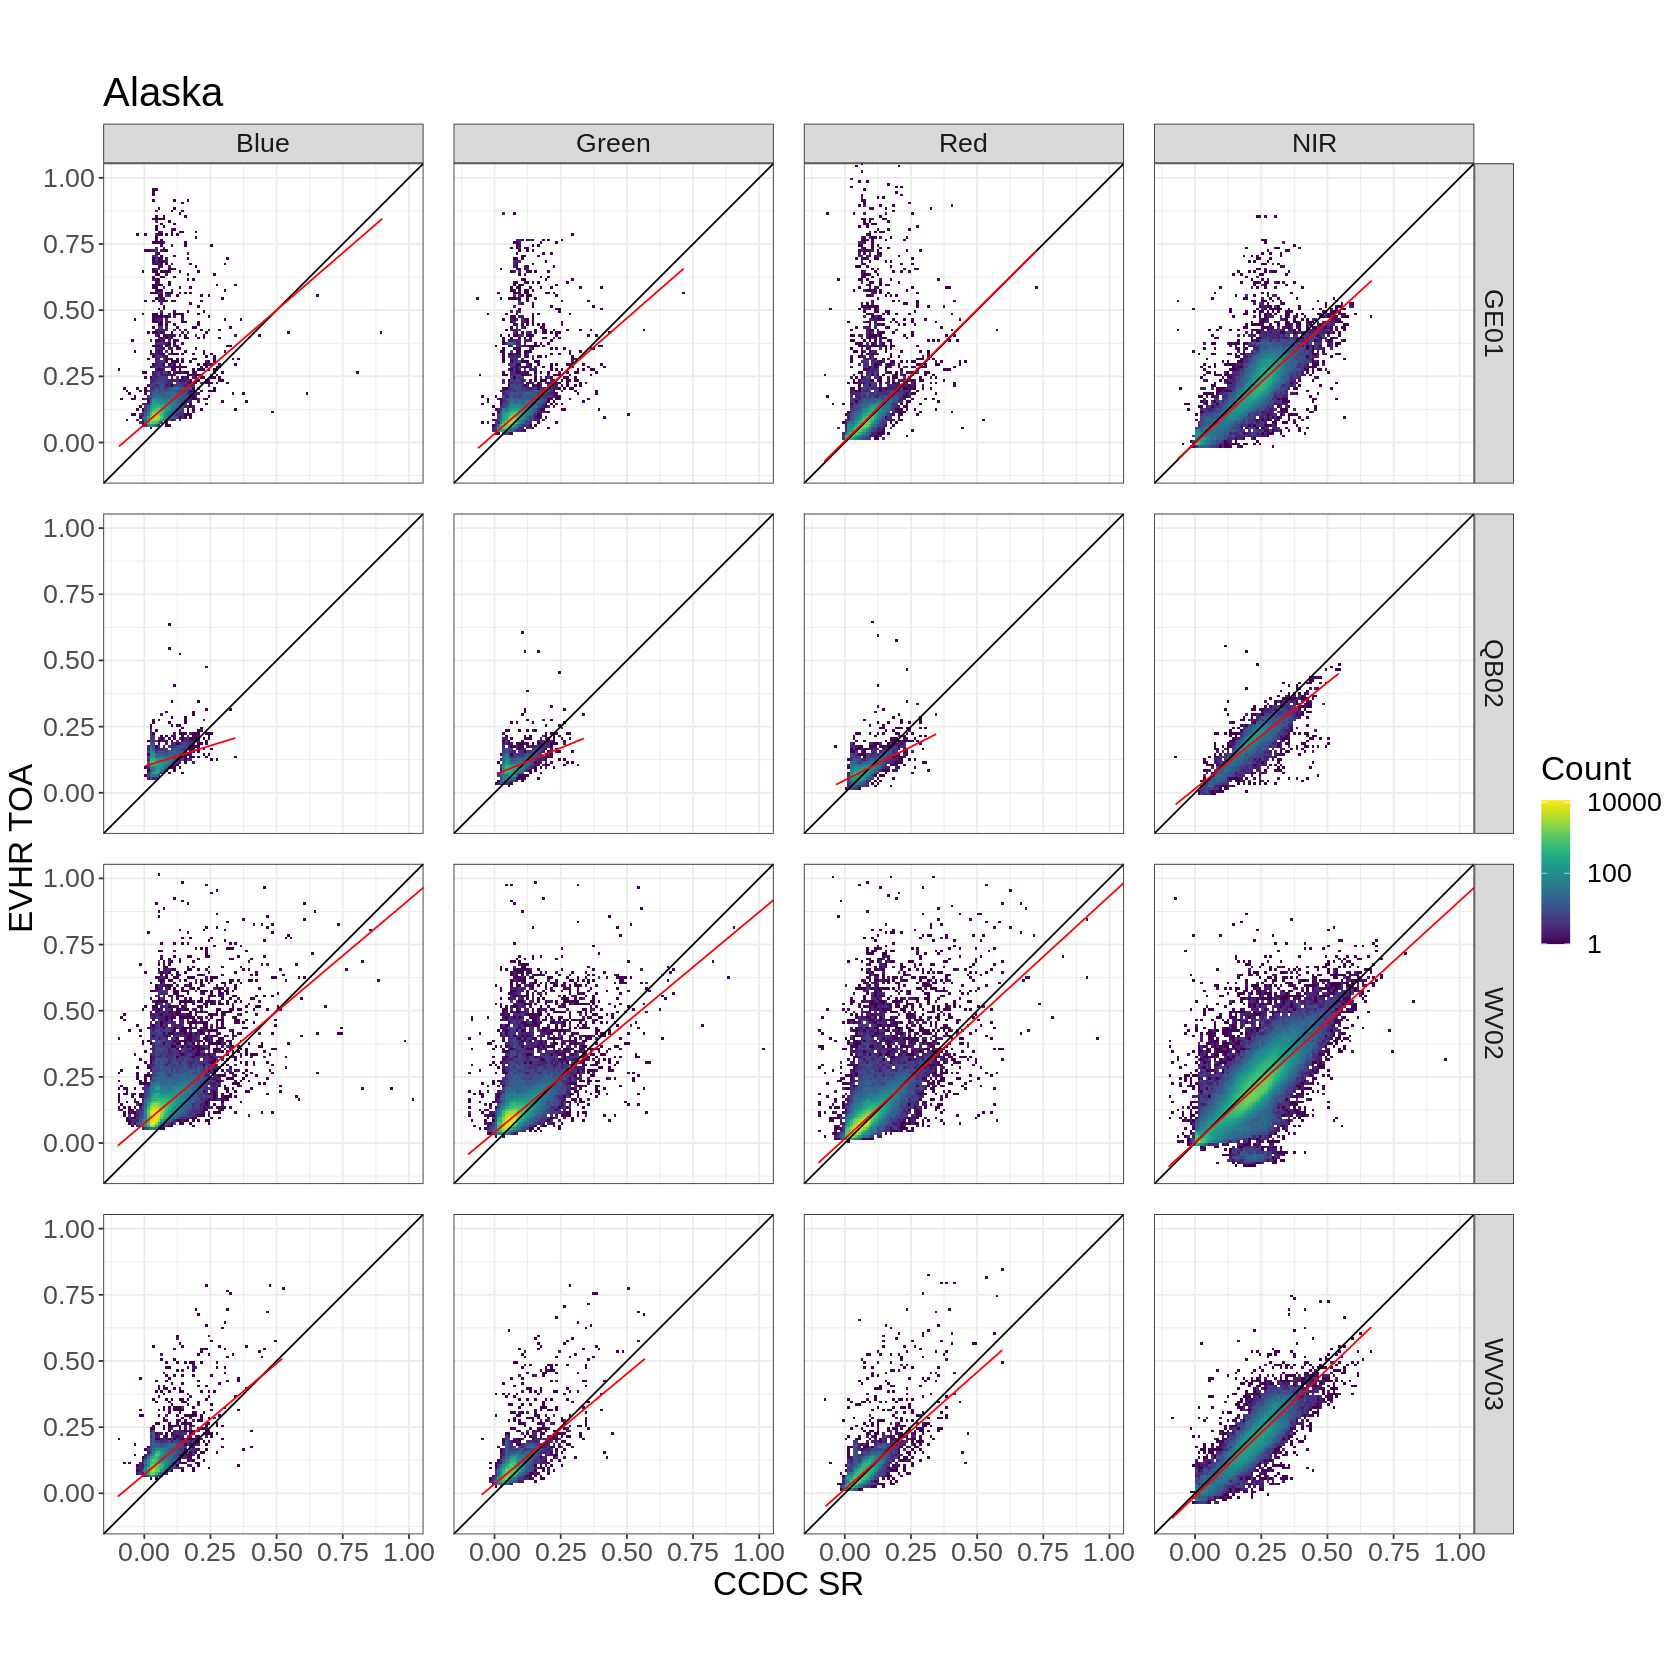

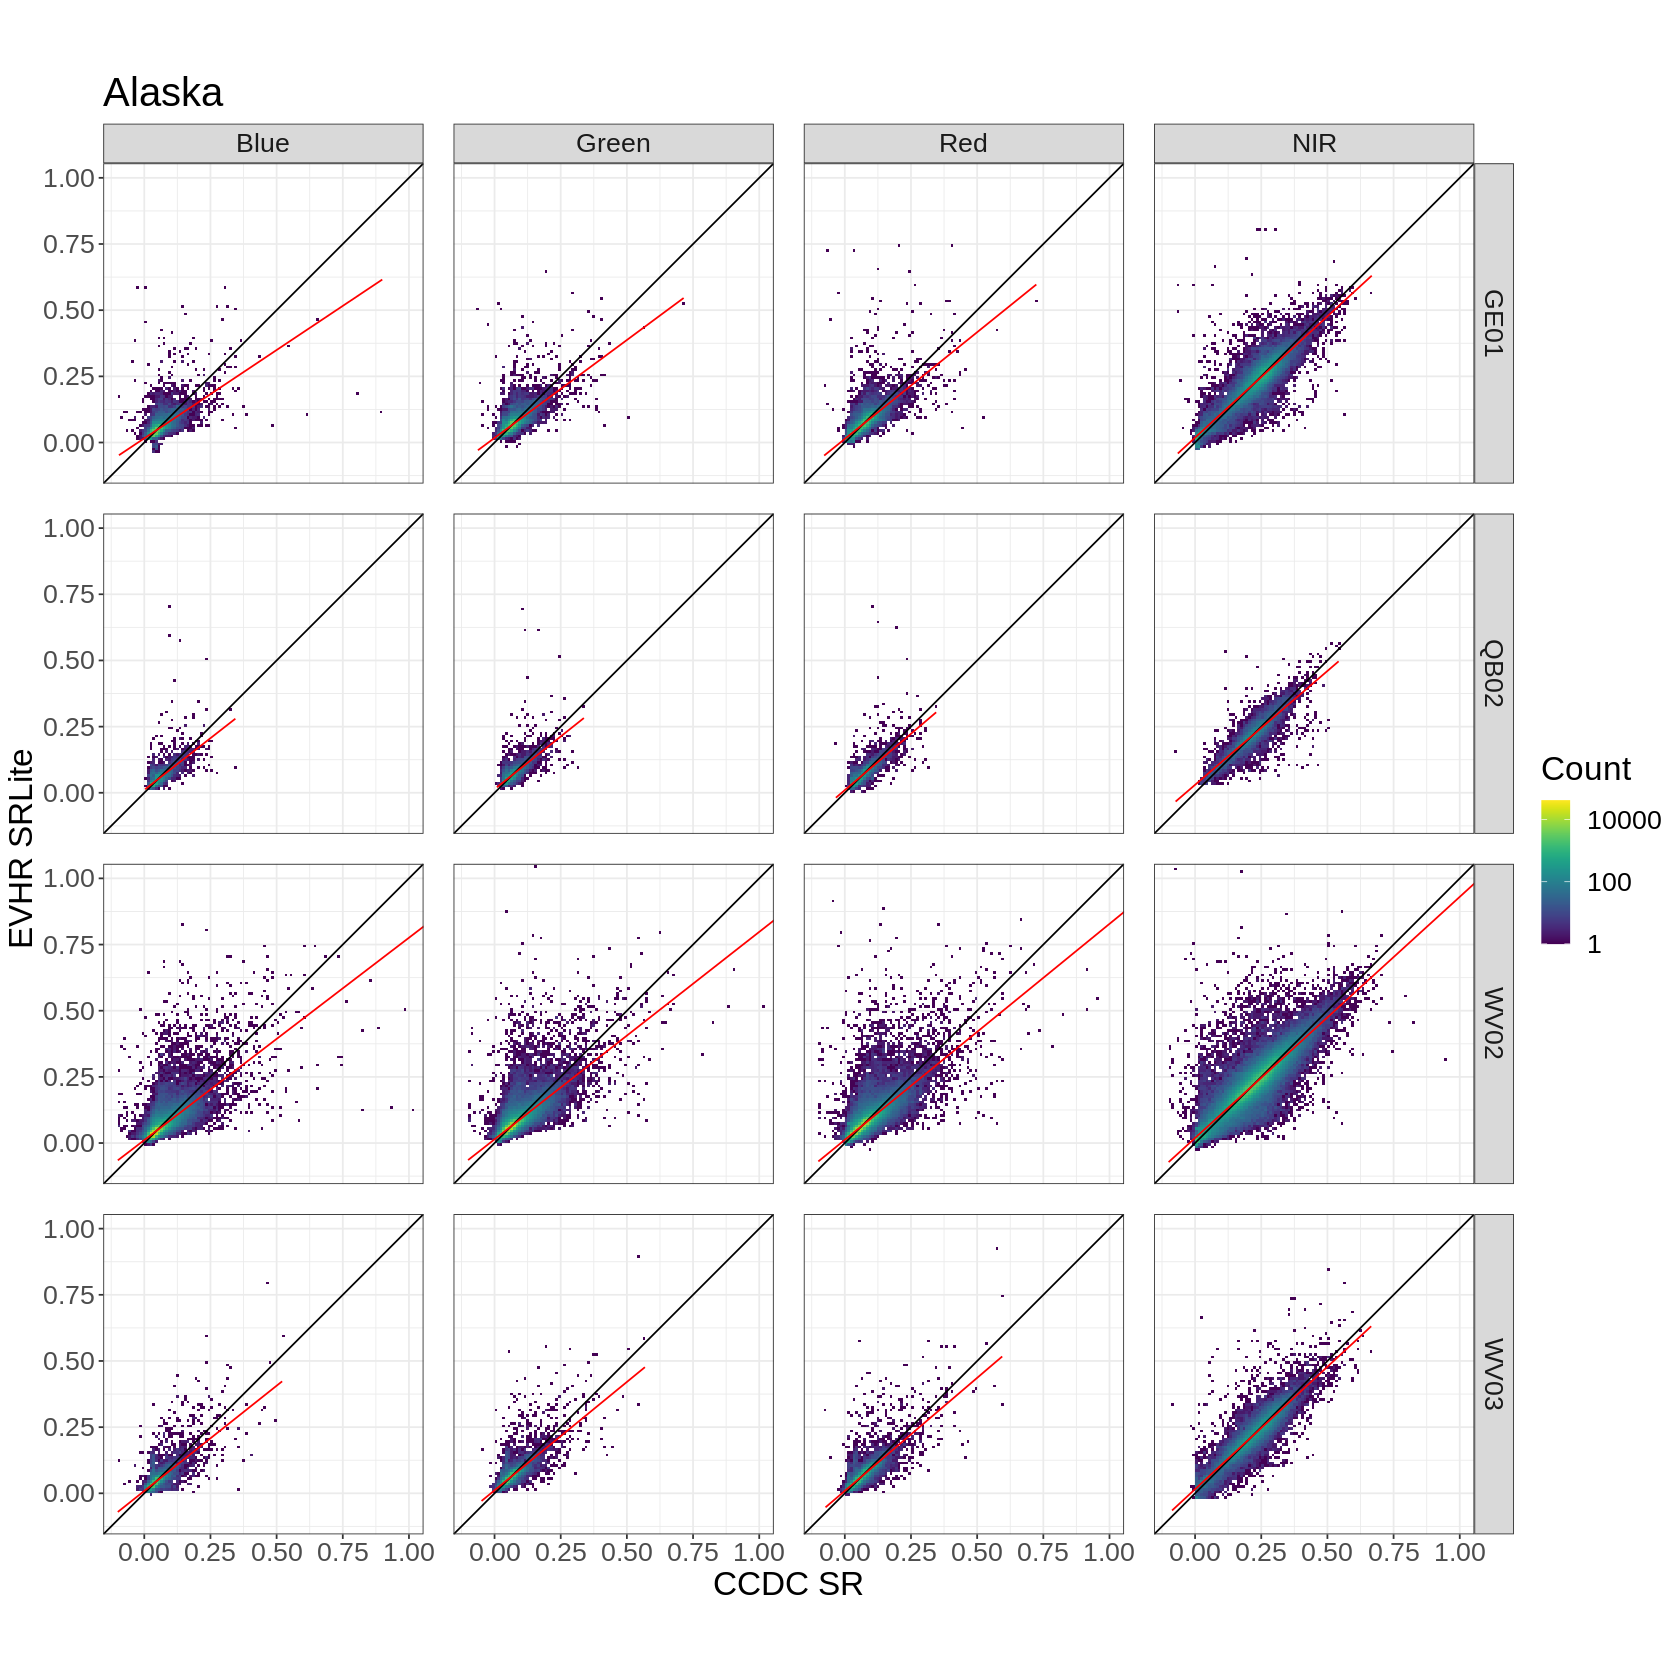

In [15]:
options(repr.plot.width = 14, repr.plot.height = 14)

reflectance_scatter <- function(data, x, y, binWidth, reflMin, reflMax, title) { #xlab, ylab, title) {
  # print(x)
  xname = select(data, {{ x }}) %>% colnames()
  yname = select(data, {{ y }}) %>% colnames()
  
  ggplot(data, aes(x={{ x }}, y={{ y }})) +
  # ggplot(data, aes(x=CCDC_SR, y=EVHR_SRLite)) +
    # coord_fixed() +
    coord_cartesian(xlim=c(reflMin,reflMax), ylim=c(reflMin,reflMax)) +
    geom_bin2d(binwidth=binWidth, color=NA) + # Geometric object to use for drawing
    # scale_fill_cmap(trans='log10', name='Count') +
    scale_fill_viridis(trans='log10', name='Count') +
    scale_color_viridis(trans='log10', name='Count') +
    geom_abline(slope = 1, intercept = 0, size=0.5)+
    geom_smooth(method = 'lm', color='red', size=0.5, se=F) +
    #facet_wrap('Band', nrow=1) +#, scales='free') +
    facet_grid(satellite ~ Band) +
    theme_bw() +
    theme(text = element_text(size=20),
          aspect.ratio = 1,
          panel.spacing = unit(0.25, 'inch')) +
            # subplots_adjust={'wspace': 0.25, 'hspace': 0.25}) + # add spacing between facets to make y-axis ticks visible
            # axis.text and strip.text and labs x & y 
    xlab(str_replace(xname, '_', ' ')) +
    ylab(str_replace(yname, '_', ' ')) +
    ggtitle(title) 
    
}

reflectance_scatter_by_region <- function(data, x, y, binWidth, reflMin, reflMax, region) {
  xname = select(data, {{ x }}) %>% colnames()
  yname = select(data, {{ y }}) %>% colnames()
  reflectance_scatter(data %>% filter(region == {{ region }}), {{ x }}, {{ y }}, binWidth, reflMin, reflMax, region)
  #ggsave(path(wDir, '20221028', 'plots', glue('{region}_{yname}_v_{xname}.png')), width=5, height=4, dpi=600)
}

# reflectance_scatter(reflect_df_long %>% filter(region == 'Whitesands'), CCDC_SR, EVHR_TOA, 0.002, -0.1, 1, 'Whitesands')
reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_TOA, 0.01, -0.1, 1, 'Alaska')
reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 0.01, -0.1, 1, 'Alaska')
#reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 0.002, -0.1, 1, 'Alaska')
#reflectance_scatter_by_region(reflect_df_long, CCDC_SR, EVHR_SRLite, 1, 'CCDC SR', 'EVHR SRLite', 'title', 'Whitesands')

# cn = select(reflect_df_long, 'CCDC_SR') %>% colnames()
# print(cn)
# cn
# cn[1]
# class(cn)
# reflectance_scatter(reflect_df_long, CCDC_SR, EVHR_TOA, 1, 'CCDC SR', 'EVHR TOA', 'title')

`geom_smooth()` using formula 'y ~ x'



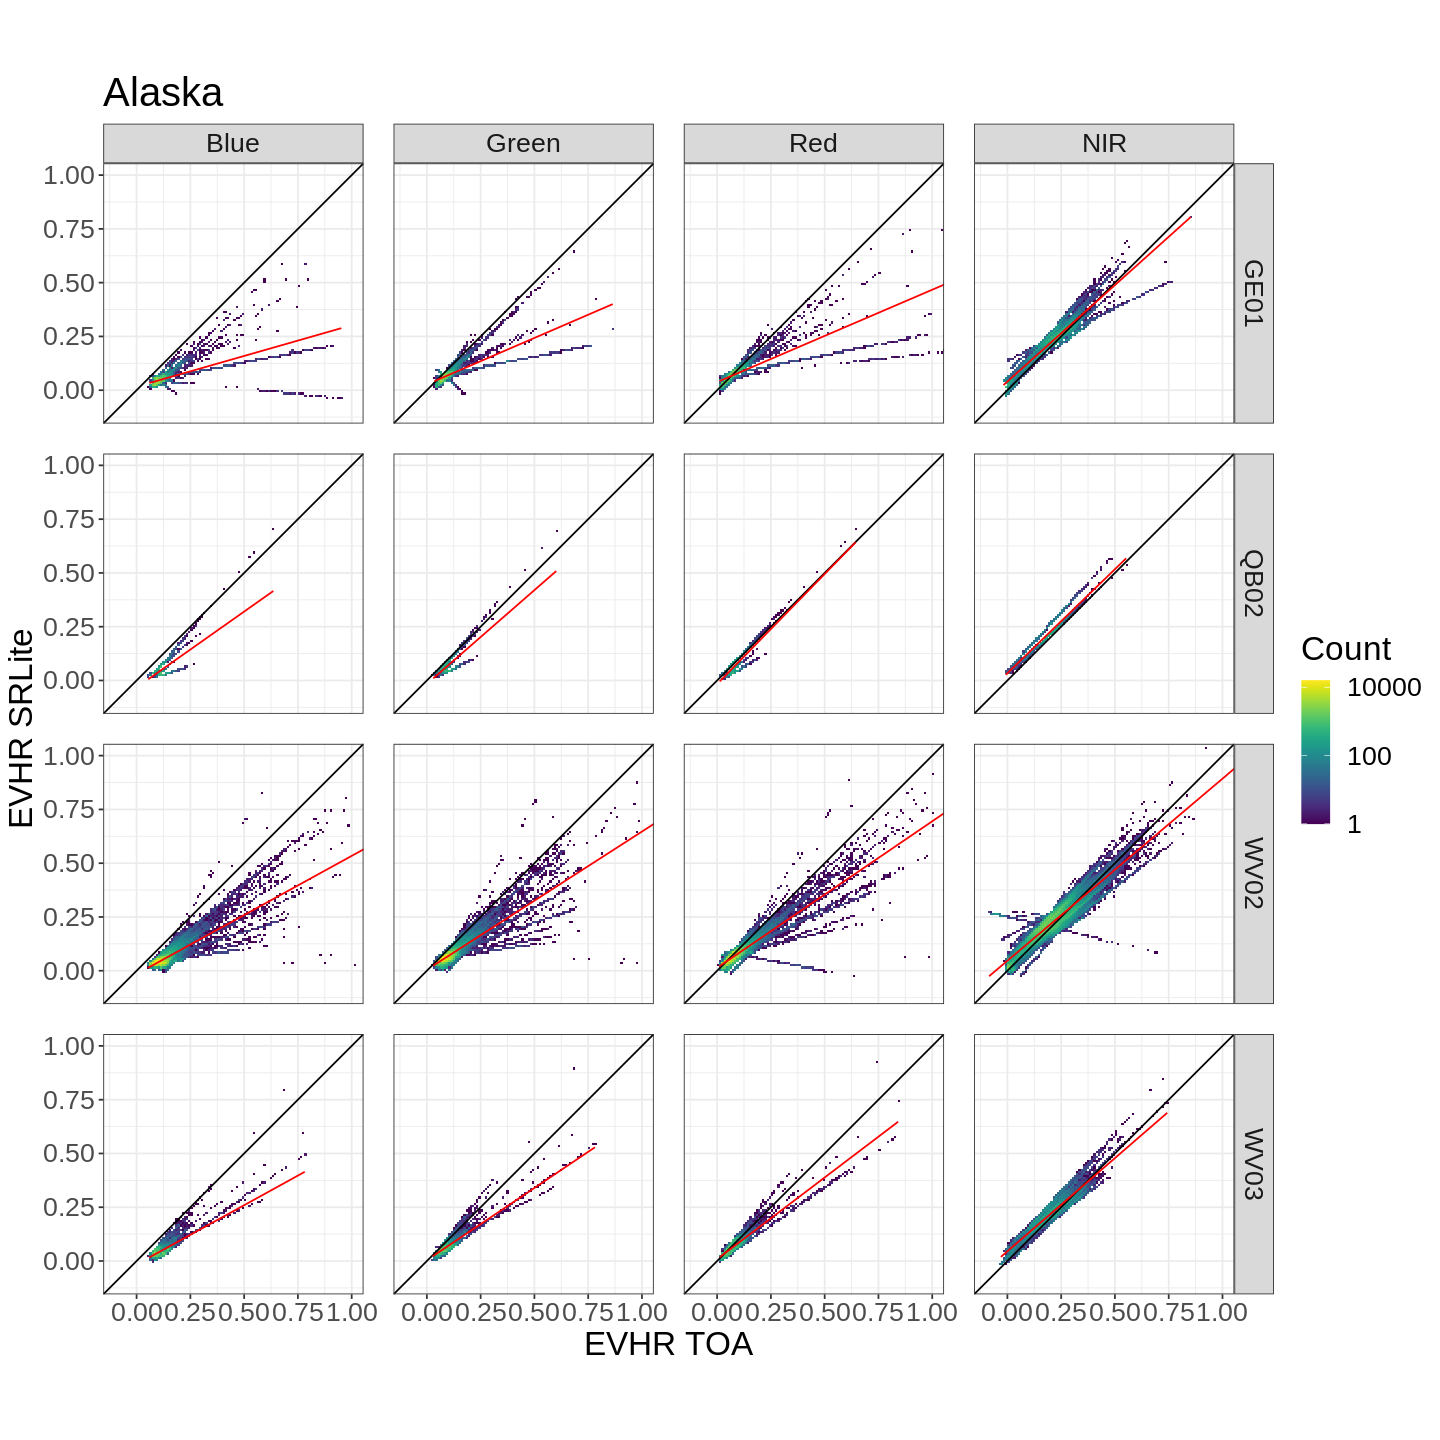

In [16]:
options(repr.plot.width = 12, repr.plot.height = 12)
reflectance_scatter_by_region(reflect_df_long, EVHR_TOA, EVHR_SRLite, 0.01, -0.1, 1, 'Alaska')

# Read VHR attributes table
from vhr_xml_dataframe.ipynb  

In [17]:

#vhr_df = read_csv('/explore/nobackup/people/pmontesa/srlite/srlite_alaska_igarss.csv', show_col_types = FALSE)
vhr_df = st_read('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_srlite_alaska_igarss.gpkg')

# Filter by catid list
vhr_df = vhr_df %>% filter(catid %in% catid_list)

dim(vhr_df)
vhr_df %>% group_by(sensor) %>%
    dplyr::summarize(cnt = n()) %>%
    as.data.frame()
#head(vhr_df %>% filter(sensor == 'GE01' | sensor == 'QB02'))
#head(vhr_df %>% select(id, sunel, sunaz, az, sensor))
#levels(factor(vhr_df$sensor))

Reading layer `footprints_vhrmeta_srlite_alaska_igarss' from data source 
  `/panfs/ccds02/nobackup/people/pmontesa/srlite/footprints_vhrmeta_srlite_alaska_igarss.gpkg' 
  using driver `GPKG'
Simple feature collection with 172 features and 18 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -166.089 ymin: 54.94875 xmax: -130.1822 ymax: 71.04099
Geodetic CRS:  WGS 84


[1] 170  19

sensor,cnt,geom
<chr>,<int>,<MULTIPOLYGON [°]>
GE01,24,MULTIPOLYGON (((-161.9253 6...
QB02,4,MULTIPOLYGON (((-154.7426 6...
WV02,121,MULTIPOLYGON (((-159.3736 5...
WV03,21,MULTIPOLYGON (((-153.9094 6...


[1] 170  19

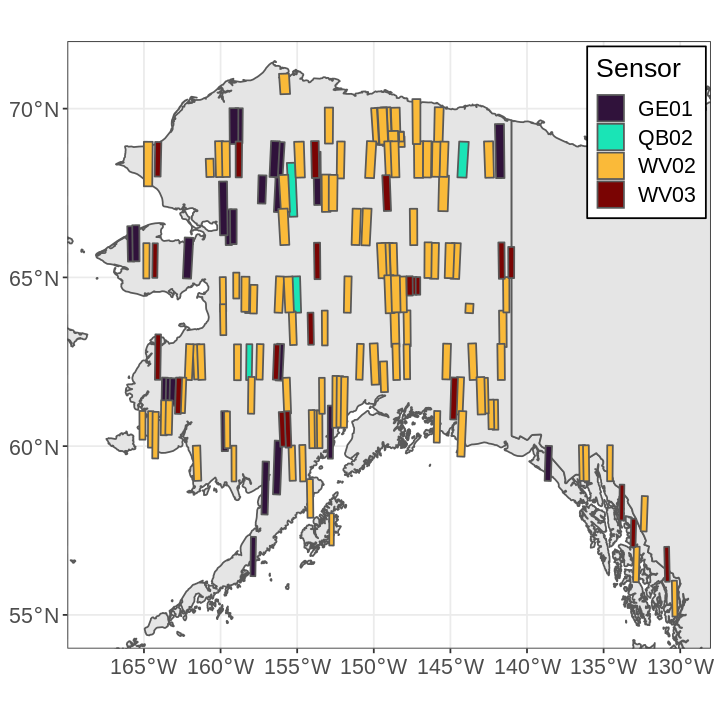

In [21]:
options(repr.plot.width = 6, repr.plot.height = 6)
dim(vhr_df)
worldmap = ne_countries(scale = 10, returnclass = 'sf')
map_vhr = ggplot() + 
    geom_sf(data=worldmap) +
    geom_sf(data=vhr_df, aes(fill=sensor)) + 
    scale_fill_viridis_d(option = 'turbo', name='Sensor') +
    theme_bw() +
    theme(text = element_text(size=16), legend.position = c(0.9, 0.85) )+
    theme(legend.background = element_rect(colour = 'black', fill = 'white', linetype='solid')) +
    coord_sf(xlim = c(-170, -128), ylim = c(54, 72), expand = FALSE)

map_vhr

#### Read in an image and place it on the plot  
image of polar plot from python code  
https://www.littlemissdata.com/blog/patchwork

In [12]:
library(magick)
library(ggimage)
library(ggpubr)

Warning message:
“package ‘ggpubr’ was built under R version 4.1.3”


ERROR: Error: package or namespace load failed for ‘ggpubr’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace ‘tidyr’ 1.1.4 is already loaded, but >= 1.3.0 is required


In [8]:
polar_plot_image <- image_read('/explore/nobackup/people/pmontesa/userfs02/projects/srlite/plots/igarss_srlite_alaska_polarplot.png')
ggplot() + background_image(polar_plot_image) + coord_fixed()

ERROR: Error in background_image(polar_plot_image): could not find function "background_image"


# Slope (SRlite ~ TOA) vs sunel

In [313]:
select(reflect_df_long,  'EVHR_TOA' ) %>% colnames()

[1] "EVHR_TOA"

In [322]:
names(vhr_df)

[1] "footprint_name" "path_x"         "file_x"         "area_km2"      
 [5] "area_ha"        "type"           "name"           "file_y"        
 [9] "path_y"         "catid"          "sensor"         "year"          
[13] "month"          "id"             "el"             "az"            
[17] "sunel"          "sunaz"          "geom"

`summarise()` has grouped output by 'Band', 'catid', 'satellite'. You can override using the `.groups` argument.



[1] "model slopes from samples of NIR band relationships for 170 images"


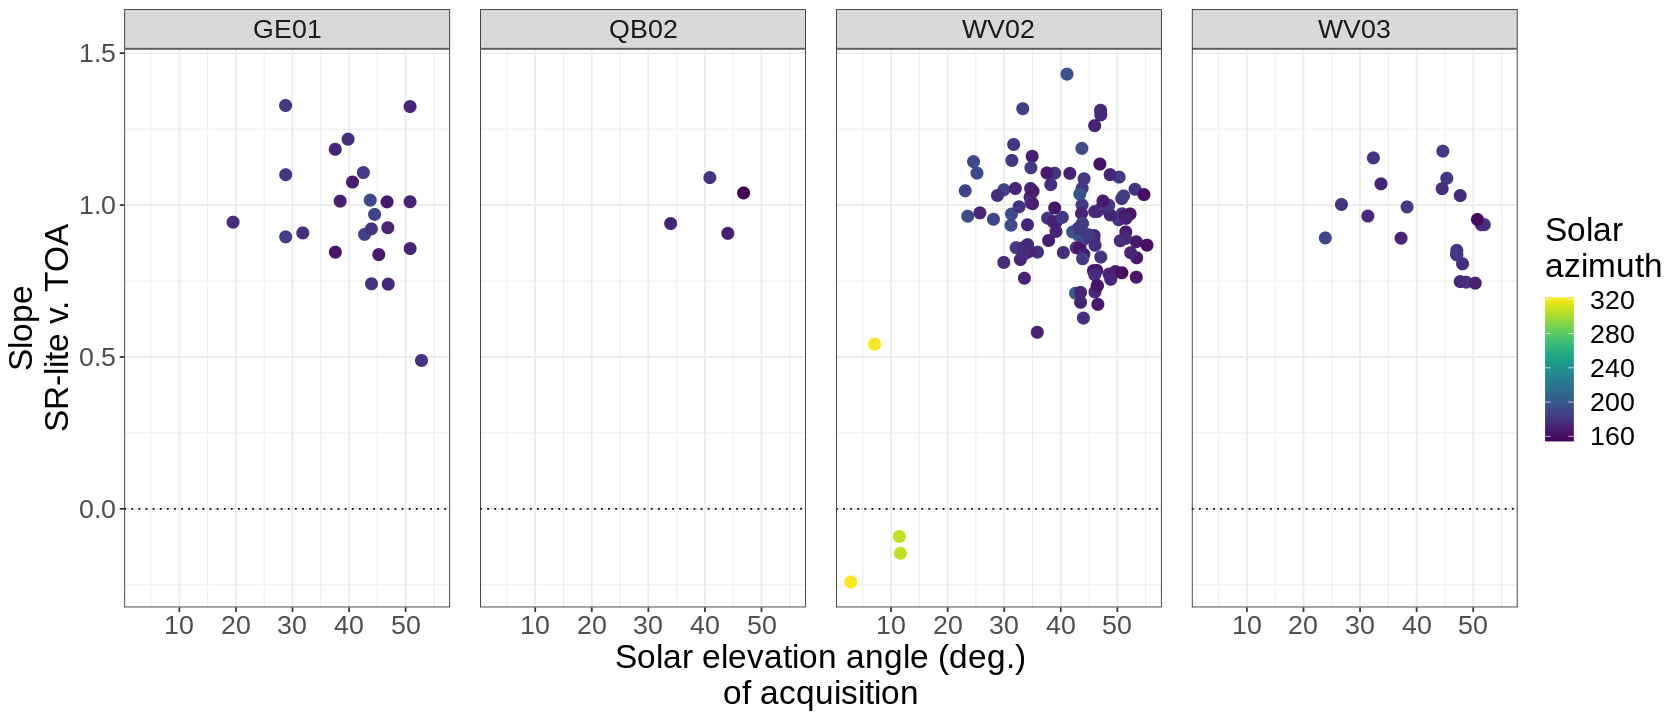

In [324]:
options(repr.plot.width = 14, repr.plot.height = 6)

library(broom)

#X_VAR = select(reflect_df_long, 'EVHR_TOA') %>% colnames()
#X_VAR = 'EVHR_TOA'

smry_slope = reflect_df_long %>% 
    filter(region == 'Alaska', Band == 'NIR') %>%
    nest_by(Band, catid, satellite) %>%
    mutate(mod = list(lm(EVHR_SRLite ~ EVHR_TOA, data = data))) %>% 
    summarize(tidy(mod)) %>% filter(term != '(Intercept)') %>% 
    left_join(vhr_df %>% select(catid, sunel, sunaz, el, az), by = c('catid' = 'catid'))
    #summarize(glance(mod))
    #summarize(augment(mod))
N_catids = dim(smry_slope)[1]
print(paste0('model slopes from samples of NIR band relationships for ', N_catids, ' images'))
smry_slope %>%
    ggplot(aes(x = sunel, y = estimate)) +
        geom_point(aes(color = sunaz), shape = 19, size = 3) +
        scale_color_viridis(name = 'Solar\nazimuth') +
        #facet_grid(satellite ~ Band) +
        facet_wrap(~satellite, ncol=4) +
        geom_hline(aes(yintercept=0), linetype = 'dotted') +
        labs(y = 'Slope\nSR-lite v. TOA', x = 'Solar elevation angle (deg.)\nof acquisition', 
             #caption= paste0('model slopes from samples of NIR band relationships for ', N_catids, ' images')
            ) +
    theme_bw() +
    theme(text = element_text(size=20),
          panel.spacing = unit(0.25, 'inch'))

#tail(smry_slope)